In [1]:
# Imports
import gzip # as some instance files may have been compressed

# Re-import dependencies (in case earlier import was skipped)
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from permutationsga.ga import (
    ConfigurableGA,

    RandomPermutationInitialization,
    crossover_ox,
    crossover_cx,
    crossover_pmx,
    TournamentSelection,
    FunctionBasedRecombinator,
    SequentialSelector,
    generate_uniform_indices,
    generate_sequential_indices,
    generate_sequential_wrapping_indices,

    RandomUniformInitialization,
    DifferentialEvolutionRecombinator,
    
    
)
from permutationsga.problem import IdenticalDecoder, InvPermDecoder, RandomKeysDecoder

from permutationsga.qap import QAP, read_qaplib
from mutation_initialization.frequency_restricted_initialization import FrequencyRestrictedInitialization

In [2]:
# The bur* instances are those that we will be using - note that we are only using 26 keys in this case.
problem = QAP(*read_qaplib("./instances/qap/bur26a.dat"))

In [3]:
distance_matrix = problem.A
frequency_matrix = problem.B

if distance_matrix[0][0] == 53:
    type = 0
if distance_matrix[0][0] == 37:
    type = 1
else:
    Exception("The distance matrix is not as expected")

row_sum = np.sum(frequency_matrix, axis = 1)
col_sum = np.sum(frequency_matrix, axis = 0)
frequencies = np.add(row_sum, col_sum)
high_frequency = np.argsort(frequencies)[-9:]
print(f"type: {type}, high frequency characters: {high_frequency}")

type: 0, high frequency characters: [11  7 18  0 19 17  8 13  4]


In [4]:
problem = IdenticalDecoder(problem) 

In [5]:
# GA - Permutation
seed = 42
population_size = 2**10
rng = np.random.default_rng(seed=seed + 1)
l = problem.get_length()


crossover_fn = crossover_pmx; indices_gen = lambda: generate_sequential_indices(rng, l)
# crossover_fn = crossover_pmx; indices_gen = lambda: generate_uniform_indices(rng, l, 0.5)
# crossover_fn = crossover_ox; indices_gen = lambda: generate_sequential_indices(rng, l)
# crossover_fn = crossover_cx; indices_gen = lambda: rng.integers(0, l - 1, size=1)
# crossover_fn = crossover_cx; indices_gen = lambda: generate_uniform_indices(rng, l, 0.05)

p = 1e-2
initialization = FrequencyRestrictedInitialization(p, type, high_frequency)
#initialization = RandomPermutationInitialization(l)
parent_selection = SequentialSelector()
recombinator = FunctionBasedRecombinator(
    indices_gen,
    crossover_fn,
    parent_selection,
    population_size * 2, # Note: double as we are including the previous population
    include_what="population"
)
selection = TournamentSelection()
ga = ConfigurableGA(
    seed, population_size, problem, initialization, recombinator, selection
)


In [6]:
ga.generation()


In [7]:
print(ga.population[0].e)

[24  9 21 15 10  5 23 22 14  6  0 18 13  7  8 11 19 17  4  3  2 20 25  1
 16 12]


In [8]:
# Current best & worst
min(s.f for s in ga.population), max(s.f for s in ga.population)

(5526271.0, 5966547.0)

In [9]:
print(ga.population[0].e)

[24  9 21 15 10  5 23 22 14  6  0 18 13  7  8 11 19 17  4  3  2 20 25  1
 16 12]


Recombine & Select (repeat a few times to see how things evolve!):

In [10]:
differences = []
p = 1e-2
seed = 42
population_size = 2**10
rng = np.random.default_rng(seed=seed + 1)
l = problem.get_length()


crossover_fn = crossover_pmx; indices_gen = lambda: generate_sequential_indices(rng, l)
# crossover_fn = crossover_pmx; indices_gen = lambda: generate_uniform_indices(rng, l, 0.5)
# crossover_fn = crossover_ox; indices_gen = lambda: generate_sequential_indices(rng, l)
# crossover_fn = crossover_cx; indices_gen = lambda: rng.integers(0, l - 1, size=1)
#crossover_fn = crossover_cx; indices_gen = lambda: generate_uniform_indices(rng, l, 0.05)

initialization = FrequencyRestrictedInitialization(p, type, high_frequency)
#initialization = RandomPermutationInitialization(l)
parent_selection = SequentialSelector()
recombinator = FunctionBasedRecombinator(
    indices_gen,
    crossover_fn,
    parent_selection,
    population_size * 2, # Note: double as we are including the previous population
    include_what="population"
)
selection = TournamentSelection()
ga = ConfigurableGA(
    seed, population_size, problem, initialization, recombinator, selection
)
while True:
    ga.generation()
    differences.append(max(s.f for s in ga.population) - min(s.f for s in ga.population))
    if differences[-1] == 0:
        break


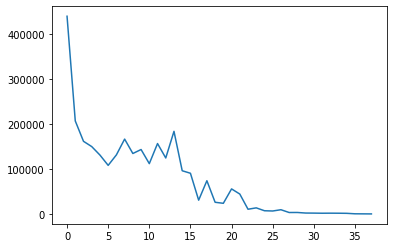

In [11]:
# plot the differences in plt.line
plt.plot(differences)

In [12]:
print(len(differences))

38


In [13]:
# Current best & worst
min(s.f for s in ga.population), max(s.f for s in ga.population)

(5438918.0, 5438918.0)

In [14]:
# print the genotype of the best
print(ga.population[np.argmin(s.f for s in ga.population)].e)

[ 1 22 12 10  6 20 23 25 14  3 19 11 17  7 13  0  8 18  4  2 21  9  5 15
 16 24]


In [15]:
# Tuning the p value
p_values = [1e-2, 1e-3, 1e-4, 1e-5, 1e-6]
results = []

for p in p_values:
    differences = []
    p = 1e-2
    seed = 42
    population_size = 2**10
    rng = np.random.default_rng(seed=seed + 1)
    l = problem.get_length()


    crossover_fn = crossover_pmx; indices_gen = lambda: generate_sequential_indices(rng, l)
    # crossover_fn = crossover_pmx; indices_gen = lambda: generate_uniform_indices(rng, l, 0.5)
    # crossover_fn = crossover_ox; indices_gen = lambda: generate_sequential_indices(rng, l)
    # crossover_fn = crossover_cx; indices_gen = lambda: rng.integers(0, l - 1, size=1)
    #crossover_fn = crossover_cx; indices_gen = lambda: generate_uniform_indices(rng, l, 0.05)

    initialization = FrequencyRestrictedInitialization(p, type, high_frequency)
    parent_selection = SequentialSelector()
    recombinator = FunctionBasedRecombinator(
        indices_gen,
        crossover_fn,
        parent_selection,
        population_size * 2, # Note: double as we are including the previous population
        include_what="population"
    )
    selection = TournamentSelection()
    ga = ConfigurableGA(
        seed, population_size, problem, initialization, recombinator, selection
    )
    while True:
        ga.generation()
        differences.append(max(s.f for s in ga.population) - min(s.f for s in ga.population))
        if differences[-1] == 0:
            break
    
    results.append(min(s.f for s in ga.population))
    
print(results)
print(f"best results: {min(results)} with p = {p_values[np.argmin(results)]}")

[5438918.0, 5438918.0, 5438918.0, 5438918.0, 5438918.0]
best results: 5438918.0 with p = 0.01
